In [1]:
# if use colab, run this part
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/539_notebook/ASL_539_Project')

Mounted at /content/drive


## Data Preprocessing Part

In [2]:
# imports
TESTING = False
TRAINING = True
import sys
print(sys.executable)
import pandas as pd
from PIL import Image
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch
import torchvision
import torch.optim as optim
import os
from tqdm import tqdm
from torchvision.ops import box_iou
import numpy as np
import matplotlib.pyplot as plt

/usr/bin/python3


In [3]:
# check if cuda is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [4]:
# load in data

train_annotation = pd.read_csv('data/train/_annotations.csv')
val_annotation = pd.read_csv('data/valid/_annotations.csv')
test_annotation = pd.read_csv('data/test/_annotations.csv')

if TESTING: #reduce data size to increase testing speed
    train_annotation = train_annotation[:100]

# print the number of samples of the data
print("Number of training, validation and testing samples")
print(len(train_annotation))
print(len(val_annotation))
print(len(test_annotation))

# check the dimension of image is the same
print("min and max width and height of training images: ", train_annotation['width'].min(), train_annotation['width'].max(), train_annotation['height'].min(), train_annotation['height'].max())
print("min and max width and height of validation images: ", val_annotation['width'].min(), val_annotation['width'].max(), val_annotation['height'].min(), val_annotation['height'].max())
print("min and max width and height of testing images: ", test_annotation['width'].min(), test_annotation['width'].max(), test_annotation['height'].min(), test_annotation['height'].max())

Number of training, validation and testing samples
1512
144
72
min and max width and height of training images:  512 512 512 512
min and max width and height of validation images:  512 512 512 512
min and max width and height of testing images:  512 512 512 512


In [5]:
# function map the class name to an integer
def charToVal(c):
    return ord(c) - 64

def valToChar(v):
    return chr(v + 64)

## Dataset Class

In [6]:
# image dimension
img_width = 512
img_height = 512

In [7]:
# create the dataset class

class ASLDataset(Dataset):
    """
    Custom ASL dataset needed for training
    """
    def __init__(self, annotation, img_dir, transforms=None):
        # initialize the annotation, paths to images, and transforms
        self.annotation = annotation
        self.img_dir = img_dir
        self.transforms = transforms

    def __len__(self):
        # return the length of the dataset
        return len(self.annotation)

    def __getitem__(self, idx):
        filename = self.annotation.at[idx, 'filename']

        class_name = self.annotation.at[idx, 'class']
        xmin = self.annotation.at[idx, 'xmin']
        xmax = self.annotation.at[idx, 'xmax']
        ymin = self.annotation.at[idx, 'ymin']
        ymax = self.annotation.at[idx, 'ymax']

        # read in the image
        path = os.path.join(self.img_dir, filename)
        img = Image.open(path).convert("RGB")

        if self.transforms is not None:
            img = self.transforms(img)

        # target
        target = {}
        target['boxes'] = torch.as_tensor([[xmin, ymin, xmax, ymax]], dtype=torch.float32)
        target['labels'] = torch.as_tensor([charToVal(class_name)], dtype=torch.int64)

        return img, target

In [8]:
# define the transforms
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

# create the dataset
train_dataset = ASLDataset(train_annotation, 'data/train', data_transform)
val_dataset = ASLDataset(val_annotation, 'data/valid', data_transform)
test_dataset = ASLDataset(test_annotation, 'data/test', data_transform)

## Model Training Part

In [9]:
def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    intersection = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    areaA = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    areaB = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    return intersection / float(areaA + areaB - intersection)

In [10]:
def find_best_iou(pred_box, target_box):
    best_iou = 0
    best_index = -1
    for i, box in enumerate(pred_box):
        curr_iou = iou(box, target_box)
        if curr_iou > best_iou:
            best_iou = curr_iou
            best_index = i
    return best_iou, best_index

#test find best iou

target_box = np.array([32., 15., 263., 326.,])
pred_boxes = np.array([[37., 65., 395., 512.], [75.232, 161.32132, 401.234, 486.213]])

best_iou, best_idx = find_best_iou(pred_boxes, target_box)
print(best_iou, best_idx)

0.3423121640133071 0


In [11]:
# collate function
def collate_fn(batch):
    images, targets = zip(*batch)
    images = list(images)
    targets = list(targets)
    return images, targets

In [12]:
# initialize dataloaders
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [ ]:
# check for possible classes in the dataloader

classes = []
for images, targets in tqdm(train_dataloader):
    for target in targets:
        classes.append(target['labels'][0].item())
classes = set(classes)
print(classes)

100%|██████████| 189/189 [00:04<00:00, 41.17it/s]

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}


In [ ]:
# check the dataloader
images, targets = next(iter(train_dataloader))
print(images)
print(targets)

[tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0

In [ ]:
# find the best learning rate
lr_list =[1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
loss_list = []

for lr in lr_list:
    # define the model
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    num_classes = 27
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    # define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # move the model to the device
    model.to(device)

    # train the model
    num_epochs = 5
    total_train_loss = 0.0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, targets in tqdm(train_dataloader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss = train_loss / len(train_dataloader)
        print("Epoch: {} Loss: {}".format(epoch, train_loss))
        total_train_loss += train_loss
    loss_list.append(total_train_loss / num_epochs)

c:\Users\tiany\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tiany\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/25 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
loss_list

[0.5308821289539336,
 0.3524891822338104,
 42.38216641914845,
 1.8355982069410655e+28,
 nan]

best learning rate: 0.0001

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# directly train a model
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

In [ ]:
backbone = torchvision.models.mobilenet_v2(pretrained=False).features
backbone.out_channels = 1280

anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                      aspect_ratios=((0.5, 1.0, 2.0),))

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)
model = FasterRCNN(backbone,
                     num_classes=27,
                     rpn_anchor_generator=anchor_generator,
                     box_roi_pool=roi_pooler)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import MultiScaleRoIAlign

# Load a pre-trained MobileNetV2 model and modify its backbone
backbone = torchvision.models.mobilenet_v2(pretrained=False).features
backbone.out_channels = 1280  # MobileNetV2's feature size for Faster R-CNN

# Define the anchor generator for RPN
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),  # Anchor sizes
    aspect_ratios=((0.5, 1.0, 2.0),)  # Aspect ratios
)

# Define the RoI pooler
roi_pooler = MultiScaleRoIAlign(
    featmap_names=['0'],  # Use the feature map at the 0th index in the backbone
    output_size=7,
    sampling_ratio=2
)

# Create the Faster R-CNN model
model = FasterRCNN(
    backbone,
    num_classes=27,  # Including the background
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 27)

model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidu

In [ ]:
# training preparation
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 50 if TRAINING else 1

H = {}
H['train_loss'] = []
H['val_ious'] = []
H['val_acc'] = []
H['loss_classifier'] = []
H['loss_box_reg'] = []
H['loss_objectness'] = []
H['loss_rpn_box_reg'] = []

In [ ]:
torch.cuda.empty_cache()

In [ ]:
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    loss_classifier = 0.0
    loss_box_reg = 0.0
    loss_objectness = 0.0
    loss_rpn_box_reg = 0.0
    for images, targets in tqdm(train_dataloader):
        optimizer.zero_grad()
        images = list(image.to(device) for image in images)


        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # print(len(images))
        # print(len(targets))
        # print(images)
        # print(targets)
        loss_dict = model(images, targets)
        #print('targets: ', targets)
        #print(loss_dict)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()

        train_loss += losses.item()
        loss_classifier += loss_dict['loss_classifier'].item()
        loss_box_reg += loss_dict['loss_box_reg'].item()
        loss_objectness += loss_dict['loss_objectness'].item()
        loss_rpn_box_reg += loss_dict['loss_rpn_box_reg'].item()
    print(f"Epoch {epoch + 1} Loss: {train_loss/len(train_dataloader)}")
    H["train_loss"].append(train_loss/len(train_dataloader))
    H["loss_classifier"].append(loss_classifier/len(train_dataloader))
    H["loss_box_reg"].append(loss_box_reg/len(train_dataloader))
    H["loss_objectness"].append(loss_objectness/len(train_dataloader))
    H["loss_rpn_box_reg"].append(loss_rpn_box_reg/len(train_dataloader))

    model.eval()
    mean_ious = 0.0
    mean_acc = 0.0

    with torch.no_grad():
        for images, targets in tqdm(val_dataloader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)
            #print(outputs)

            ious = []
            iou_idxs = []
            true_classes = []
            pred_classes = []

            for i, output in enumerate(outputs):
                target_box = targets[i]['boxes'][0].cpu().numpy()
                pred_boxes = output['boxes'].cpu().numpy()
                #print(pred_boxes)
                #print(target_box)
                best_iou, best_idx = find_best_iou(pred_boxes, target_box)
                ious.append(best_iou)
                iou_idxs.append(best_idx)

                true_class = targets[i]['labels'][0].cpu().numpy()
                if best_idx == -1:
                    pred_class = 0
                else:
                    pred_class = output['labels'][best_idx].cpu().numpy()
                true_classes.append(true_class)
                pred_classes.append(pred_class)

            mean_ious += sum(ious)/len(ious)
            mean_acc += sum([1 if true_classes[i] == pred_classes[i] else 0 for i in range(len(true_classes))])/len(true_classes)
    H['val_ious'].append(mean_ious/len(val_dataloader))
    H['val_acc'].append(mean_acc/len(val_dataloader))
    print(f"Epoch {epoch + 1} Mean IOU: {mean_ious/len(val_dataloader)}")
    print(f"Epoch {epoch + 1} Mean Accuracy: {mean_acc/len(val_dataloader)}")

100%|██████████| 189/189 [05:47<00:00,  1.84s/it]


Epoch 1 Loss: 0.5292692301134584


100%|██████████| 18/18 [00:34<00:00,  1.89s/it]


Epoch 1 Mean IOU: 0.6095256071690069
Epoch 1 Mean Accuracy: 0.0763888888888889


100%|██████████| 189/189 [01:14<00:00,  2.55it/s]


Epoch 2 Loss: 0.37138952575032674


100%|██████████| 18/18 [00:02<00:00,  8.59it/s]


Epoch 2 Mean IOU: 0.6834200947160415
Epoch 2 Mean Accuracy: 0.09722222222222222


100%|██████████| 189/189 [01:14<00:00,  2.54it/s]


Epoch 3 Loss: 0.338967980136947


100%|██████████| 18/18 [00:02<00:00,  8.23it/s]


Epoch 3 Mean IOU: 0.7550312360295941
Epoch 3 Mean Accuracy: 0.1875


100%|██████████| 189/189 [01:14<00:00,  2.54it/s]


Epoch 4 Loss: 0.31043347487689327


100%|██████████| 18/18 [00:02<00:00,  8.56it/s]


Epoch 4 Mean IOU: 0.7915973698858844
Epoch 4 Mean Accuracy: 0.20833333333333334


100%|██████████| 189/189 [01:14<00:00,  2.54it/s]


Epoch 5 Loss: 0.28832672394457315


100%|██████████| 18/18 [00:02<00:00,  8.34it/s]


Epoch 5 Mean IOU: 0.792326372440984
Epoch 5 Mean Accuracy: 0.2638888888888889


100%|██████████| 189/189 [01:14<00:00,  2.54it/s]


Epoch 6 Loss: 0.26476161757474226


100%|██████████| 18/18 [00:02<00:00,  8.41it/s]


Epoch 6 Mean IOU: 0.8269268320115439
Epoch 6 Mean Accuracy: 0.2708333333333333


100%|██████████| 189/189 [01:14<00:00,  2.55it/s]


Epoch 7 Loss: 0.24640627102877097


100%|██████████| 18/18 [00:02<00:00,  8.39it/s]


Epoch 7 Mean IOU: 0.8216590363780601
Epoch 7 Mean Accuracy: 0.3958333333333333


100%|██████████| 189/189 [01:14<00:00,  2.53it/s]


Epoch 8 Loss: 0.21475590284539278


100%|██████████| 18/18 [00:02<00:00,  8.22it/s]


Epoch 8 Mean IOU: 0.8389553348197676
Epoch 8 Mean Accuracy: 0.3888888888888889


100%|██████████| 189/189 [01:14<00:00,  2.53it/s]


Epoch 9 Loss: 0.20186771633763792


100%|██████████| 18/18 [00:02<00:00,  8.25it/s]


Epoch 9 Mean IOU: 0.8392712839404006
Epoch 9 Mean Accuracy: 0.3680555555555556


100%|██████████| 189/189 [01:14<00:00,  2.53it/s]


Epoch 10 Loss: 0.18227943841111724


100%|██████████| 18/18 [00:02<00:00,  8.21it/s]


Epoch 10 Mean IOU: 0.8230168444915877
Epoch 10 Mean Accuracy: 0.3611111111111111


100%|██████████| 189/189 [01:14<00:00,  2.53it/s]


Epoch 11 Loss: 0.1653158458925429


100%|██████████| 18/18 [00:02<00:00,  8.27it/s]


Epoch 11 Mean IOU: 0.8471564127917083
Epoch 11 Mean Accuracy: 0.4861111111111111


100%|██████████| 189/189 [01:14<00:00,  2.53it/s]


Epoch 12 Loss: 0.1542668055999216


100%|██████████| 18/18 [00:02<00:00,  8.49it/s]


Epoch 12 Mean IOU: 0.8413961398758069
Epoch 12 Mean Accuracy: 0.375


100%|██████████| 189/189 [01:15<00:00,  2.51it/s]


Epoch 13 Loss: 0.1409507945731834


100%|██████████| 18/18 [00:02<00:00,  7.83it/s]


Epoch 13 Mean IOU: 0.8462711045447198
Epoch 13 Mean Accuracy: 0.4236111111111111


100%|██████████| 189/189 [01:15<00:00,  2.51it/s]


Epoch 14 Loss: 0.12909736405447048


100%|██████████| 18/18 [00:02<00:00,  8.05it/s]


Epoch 14 Mean IOU: 0.8464851453430993
Epoch 14 Mean Accuracy: 0.4027777777777778


100%|██████████| 189/189 [01:16<00:00,  2.48it/s]


Epoch 15 Loss: 0.12125855514769832


100%|██████████| 18/18 [00:02<00:00,  7.91it/s]


Epoch 15 Mean IOU: 0.8514827471156572
Epoch 15 Mean Accuracy: 0.4722222222222222


100%|██████████| 189/189 [01:15<00:00,  2.49it/s]


Epoch 16 Loss: 0.11062520624153198


100%|██████████| 18/18 [00:02<00:00,  7.54it/s]


Epoch 16 Mean IOU: 0.8555164770818096
Epoch 16 Mean Accuracy: 0.4861111111111111


100%|██████████| 189/189 [01:15<00:00,  2.50it/s]


Epoch 17 Loss: 0.10477249635748132


100%|██████████| 18/18 [00:02<00:00,  7.91it/s]


Epoch 17 Mean IOU: 0.8452076628118355
Epoch 17 Mean Accuracy: 0.5138888888888888


100%|██████████| 189/189 [01:15<00:00,  2.49it/s]


Epoch 18 Loss: 0.09819073450786096


100%|██████████| 18/18 [00:02<00:00,  7.68it/s]


Epoch 18 Mean IOU: 0.8596592005514199
Epoch 18 Mean Accuracy: 0.5625


100%|██████████| 189/189 [01:15<00:00,  2.50it/s]


Epoch 19 Loss: 0.09529692585033084


100%|██████████| 18/18 [00:02<00:00,  8.04it/s]


Epoch 19 Mean IOU: 0.8610690165235791
Epoch 19 Mean Accuracy: 0.5138888888888888


100%|██████████| 189/189 [01:16<00:00,  2.48it/s]


Epoch 20 Loss: 0.09020341782973557


100%|██████████| 18/18 [00:02<00:00,  7.99it/s]


Epoch 20 Mean IOU: 0.8301140188586651
Epoch 20 Mean Accuracy: 0.4652777777777778


100%|██████████| 189/189 [01:15<00:00,  2.49it/s]


Epoch 21 Loss: 0.08502186888030597


100%|██████████| 18/18 [00:02<00:00,  7.42it/s]


Epoch 21 Mean IOU: 0.8493134847686462
Epoch 21 Mean Accuracy: 0.5069444444444444


100%|██████████| 189/189 [01:16<00:00,  2.48it/s]


Epoch 22 Loss: 0.07824607065351552


100%|██████████| 18/18 [00:02<00:00,  7.60it/s]


Epoch 22 Mean IOU: 0.8502570227001344
Epoch 22 Mean Accuracy: 0.5347222222222222


100%|██████████| 189/189 [01:16<00:00,  2.49it/s]


Epoch 23 Loss: 0.07283674750141997


100%|██████████| 18/18 [00:02<00:00,  7.55it/s]


Epoch 23 Mean IOU: 0.8628391501543522
Epoch 23 Mean Accuracy: 0.5277777777777778


100%|██████████| 189/189 [01:15<00:00,  2.49it/s]


Epoch 24 Loss: 0.07200422802220577


100%|██████████| 18/18 [00:02<00:00,  7.75it/s]


Epoch 24 Mean IOU: 0.8608375904309019
Epoch 24 Mean Accuracy: 0.5416666666666666


100%|██████████| 189/189 [01:15<00:00,  2.49it/s]


Epoch 25 Loss: 0.06908060533423273


100%|██████████| 18/18 [00:02<00:00,  7.78it/s]


Epoch 25 Mean IOU: 0.8594887736811802
Epoch 25 Mean Accuracy: 0.6319444444444444


100%|██████████| 189/189 [01:16<00:00,  2.48it/s]


Epoch 26 Loss: 0.06633653976614513


100%|██████████| 18/18 [00:02<00:00,  7.52it/s]


Epoch 26 Mean IOU: 0.8717848191069995
Epoch 26 Mean Accuracy: 0.6180555555555556


100%|██████████| 189/189 [01:16<00:00,  2.48it/s]


Epoch 27 Loss: 0.062919944189686


100%|██████████| 18/18 [00:02<00:00,  7.59it/s]


Epoch 27 Mean IOU: 0.8627551249833588
Epoch 27 Mean Accuracy: 0.5625


100%|██████████| 189/189 [01:16<00:00,  2.48it/s]


Epoch 28 Loss: 0.063599433000914


100%|██████████| 18/18 [00:02<00:00,  7.33it/s]


Epoch 28 Mean IOU: 0.8706298195976567
Epoch 28 Mean Accuracy: 0.6111111111111112


100%|██████████| 189/189 [01:16<00:00,  2.47it/s]


Epoch 29 Loss: 0.06103657739897254


100%|██████████| 18/18 [00:02<00:00,  7.66it/s]


Epoch 29 Mean IOU: 0.8681199611366723
Epoch 29 Mean Accuracy: 0.5486111111111112


100%|██████████| 189/189 [01:16<00:00,  2.47it/s]


Epoch 30 Loss: 0.05946016583650831


100%|██████████| 18/18 [00:02<00:00,  7.52it/s]


Epoch 30 Mean IOU: 0.869501338633853
Epoch 30 Mean Accuracy: 0.5763888888888888


100%|██████████| 189/189 [01:16<00:00,  2.47it/s]


Epoch 31 Loss: 0.055214618327756405


100%|██████████| 18/18 [00:02<00:00,  7.38it/s]


Epoch 31 Mean IOU: 0.8726654613171562
Epoch 31 Mean Accuracy: 0.5694444444444444


100%|██████████| 189/189 [01:16<00:00,  2.47it/s]


Epoch 32 Loss: 0.053835941862965385


100%|██████████| 18/18 [00:02<00:00,  7.48it/s]


Epoch 32 Mean IOU: 0.8621000513989804
Epoch 32 Mean Accuracy: 0.6458333333333334


100%|██████████| 189/189 [01:16<00:00,  2.47it/s]


Epoch 33 Loss: 0.05436248592441044


100%|██████████| 18/18 [00:02<00:00,  7.48it/s]


Epoch 33 Mean IOU: 0.8743317068580816
Epoch 33 Mean Accuracy: 0.5347222222222222


100%|██████████| 189/189 [01:16<00:00,  2.47it/s]


Epoch 34 Loss: 0.050965622047740945


100%|██████████| 18/18 [00:02<00:00,  7.39it/s]


Epoch 34 Mean IOU: 0.8738636350105582
Epoch 34 Mean Accuracy: 0.625


100%|██████████| 189/189 [01:16<00:00,  2.47it/s]


Epoch 35 Loss: 0.050402836332087794


100%|██████████| 18/18 [00:02<00:00,  7.90it/s]


Epoch 35 Mean IOU: 0.8765116688578983
Epoch 35 Mean Accuracy: 0.6458333333333334


100%|██████████| 189/189 [01:16<00:00,  2.48it/s]


Epoch 36 Loss: 0.04780784264088623


100%|██████████| 18/18 [00:02<00:00,  7.61it/s]


Epoch 36 Mean IOU: 0.8679709005829049
Epoch 36 Mean Accuracy: 0.6111111111111112


100%|██████████| 189/189 [01:16<00:00,  2.47it/s]


Epoch 37 Loss: 0.046822107441368555


100%|██████████| 18/18 [00:02<00:00,  7.35it/s]


Epoch 37 Mean IOU: 0.885860840922439
Epoch 37 Mean Accuracy: 0.6180555555555556


100%|██████████| 189/189 [01:16<00:00,  2.48it/s]


Epoch 38 Loss: 0.0467197930529004


100%|██████████| 18/18 [00:02<00:00,  7.10it/s]


Epoch 38 Mean IOU: 0.885532231090111
Epoch 38 Mean Accuracy: 0.6597222222222222


100%|██████████| 189/189 [01:16<00:00,  2.46it/s]


Epoch 39 Loss: 0.04464112887425082


100%|██████████| 18/18 [00:02<00:00,  7.37it/s]


Epoch 39 Mean IOU: 0.8822805210907423
Epoch 39 Mean Accuracy: 0.6388888888888888


100%|██████████| 189/189 [01:16<00:00,  2.46it/s]


Epoch 40 Loss: 0.04426075595987852


100%|██████████| 18/18 [00:02<00:00,  7.57it/s]


Epoch 40 Mean IOU: 0.883194024866209
Epoch 40 Mean Accuracy: 0.7013888888888888


100%|██████████| 189/189 [01:16<00:00,  2.47it/s]


Epoch 41 Loss: 0.042906468310368755


100%|██████████| 18/18 [00:02<00:00,  7.08it/s]


Epoch 41 Mean IOU: 0.8779097656268482
Epoch 41 Mean Accuracy: 0.6944444444444444


100%|██████████| 189/189 [01:16<00:00,  2.46it/s]


Epoch 42 Loss: 0.041467899436909685


100%|██████████| 18/18 [00:02<00:00,  7.11it/s]


Epoch 42 Mean IOU: 0.86956254641499
Epoch 42 Mean Accuracy: 0.6944444444444444


100%|██████████| 189/189 [01:16<00:00,  2.46it/s]


Epoch 43 Loss: 0.041175962884038214


100%|██████████| 18/18 [00:02<00:00,  7.47it/s]


Epoch 43 Mean IOU: 0.8834205835569493
Epoch 43 Mean Accuracy: 0.6319444444444444


100%|██████████| 189/189 [01:16<00:00,  2.47it/s]


Epoch 44 Loss: 0.040074669967883475


100%|██████████| 18/18 [00:02<00:00,  7.28it/s]


Epoch 44 Mean IOU: 0.8847151157365778
Epoch 44 Mean Accuracy: 0.6805555555555556


100%|██████████| 189/189 [01:16<00:00,  2.46it/s]


Epoch 45 Loss: 0.039796055831685266


100%|██████████| 18/18 [00:02<00:00,  7.31it/s]


Epoch 45 Mean IOU: 0.8766658297733998
Epoch 45 Mean Accuracy: 0.6666666666666666


100%|██████████| 189/189 [01:16<00:00,  2.47it/s]


Epoch 46 Loss: 0.0377944396641204


100%|██████████| 18/18 [00:02<00:00,  7.21it/s]


Epoch 46 Mean IOU: 0.8875120964038545
Epoch 46 Mean Accuracy: 0.7222222222222222


100%|██████████| 189/189 [01:16<00:00,  2.46it/s]


Epoch 47 Loss: 0.038050023040601184


100%|██████████| 18/18 [00:02<00:00,  7.08it/s]


Epoch 47 Mean IOU: 0.8795226578650408
Epoch 47 Mean Accuracy: 0.6041666666666666


100%|██████████| 189/189 [01:16<00:00,  2.45it/s]


Epoch 48 Loss: 0.036024016214820445


100%|██████████| 18/18 [00:02<00:00,  7.00it/s]


Epoch 48 Mean IOU: 0.8882273151857639
Epoch 48 Mean Accuracy: 0.5972222222222222


100%|██████████| 189/189 [01:16<00:00,  2.46it/s]


Epoch 49 Loss: 0.03657416946121624


100%|██████████| 18/18 [00:02<00:00,  7.10it/s]


Epoch 49 Mean IOU: 0.8838644294395109
Epoch 49 Mean Accuracy: 0.6666666666666666


100%|██████████| 189/189 [01:17<00:00,  2.45it/s]


Epoch 50 Loss: 0.03515372423346711


100%|██████████| 18/18 [00:02<00:00,  7.03it/s]

Epoch 50 Mean IOU: 0.887326552731058
Epoch 50 Mean Accuracy: 0.6736111111111112


In [ ]:
# save the model

if not os.path.exists('models'):
    os.makedirs('models')
torch.save(model.state_dict(), 'models/trained_model_2.pth')

In [ ]:
# test the model

model.eval()
mean_ious = 0.0
mean_acc = 0.0
overall_true_classes = []
overall_pred_classes = []

with torch.no_grad():
    for images, targets in tqdm(test_dataloader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(images)
        #print(outputs)

        ious = []
        iou_idxs = []
        true_classes = []
        pred_classes = []

        for i, output in enumerate(outputs):
            target_box = targets[i]['boxes'][0].cpu().numpy()
            pred_boxes = output['boxes'].cpu().numpy()
            #print(pred_boxes)
            #print(target_box)
            best_iou, best_idx = find_best_iou(pred_boxes, target_box)
            ious.append(best_iou)
            iou_idxs.append(best_idx)

            true_class = targets[i]['labels'][0].cpu().numpy()
            if best_idx == -1:
                pred_class = 0
            else:
                pred_class = output['labels'][best_idx].cpu().numpy()
            true_classes.append(true_class)
            pred_classes.append(pred_class)

        mean_ious += sum(ious)/len(ious)
        mean_acc += sum([1 if true_classes[i] == pred_classes[i] else 0 for i in range(len(true_classes))])/len(true_classes)
        overall_true_classes.extend(true_classes)
        overall_pred_classes.extend(pred_classes)
print(f"Test Mean IOU: {mean_ious/len(test_dataloader)}")
print(f"Test Mean Accuracy: {mean_acc/len(test_dataloader)}")

100%|██████████| 9/9 [00:20<00:00,  2.23s/it]

Test Mean IOU: 0.8737620987478151
Test Mean Accuracy: 0.6527777777777778


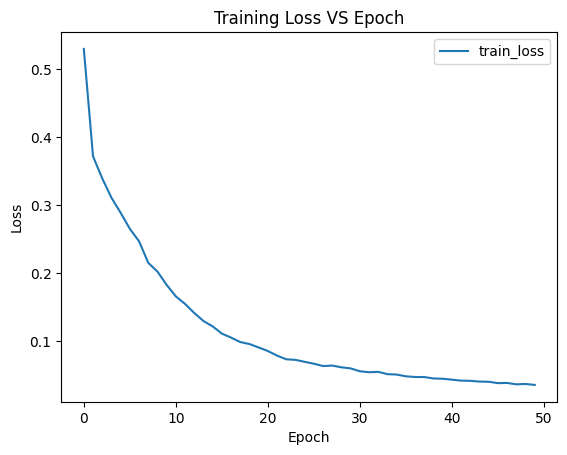

In [ ]:
# training and validation loss

plt.plot(H['train_loss'], label='train_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss VS Epoch')
plt.savefig('training_loss.png')
plt.show()

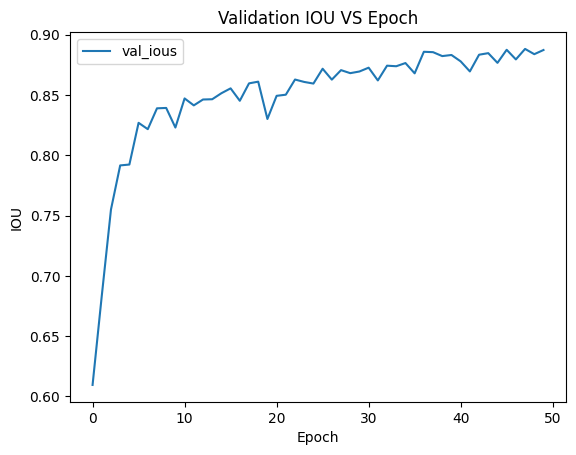

In [ ]:
# validation iou

plt.plot(H['val_ious'], label='val_ious')
plt.xlabel('Epoch')
plt.ylabel('IOU')
plt.legend()
plt.title('Validation IOU VS Epoch')
plt.savefig('validation_iou.png')
plt.show()

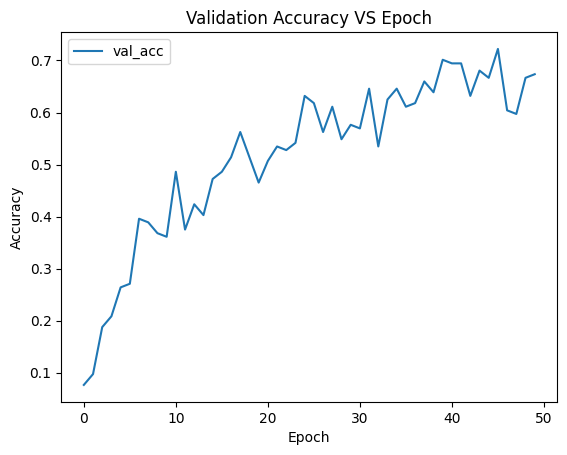

In [ ]:
# validation accuracy

plt.plot(H['val_acc'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy VS Epoch')
plt.savefig('validation_accuracy.png')
plt.show()

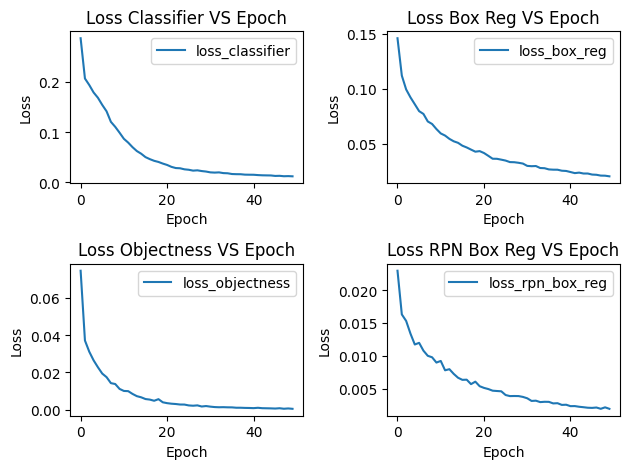

In [ ]:
# 4 loss subplots

plt.subplot(2, 2, 1)
plt.plot(H['loss_classifier'], label='loss_classifier')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Classifier VS Epoch')

plt.subplot(2, 2, 2)
plt.plot(H['loss_box_reg'], label='loss_box_reg')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Box Reg VS Epoch')

plt.subplot(2, 2, 3)
plt.plot(H['loss_objectness'], label='loss_objectness')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Objectness VS Epoch')

plt.subplot(2, 2, 4)
plt.plot(H['loss_rpn_box_reg'], label='loss_rpn_box_reg')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss RPN Box Reg VS Epoch')

plt.tight_layout()
plt.savefig('loss_subplots.png')
plt.show()


In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(overall_true_classes, overall_pred_classes)
print(cm)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 1 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 

In [ ]:
classes = list(classes)
classes = [valToChar(c) for c in classes]

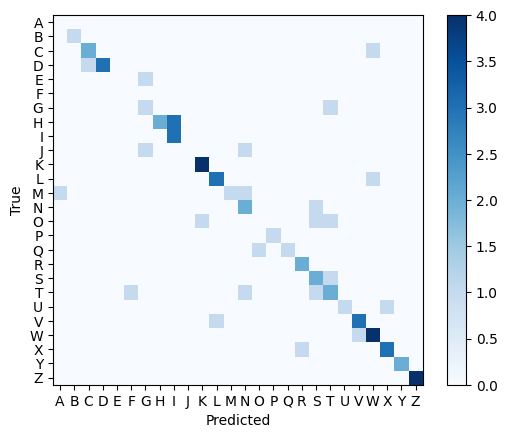

In [ ]:
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Visualization

In [ ]:
torch.cuda.is_available()

True

In [13]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import MultiScaleRoIAlign

# load best model
backbone = torchvision.models.mobilenet_v2(pretrained=False).features
backbone.out_channels = 1280  # MobileNetV2's feature size for Faster R-CNN

# Define the anchor generator for RPN
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),  # Anchor sizes
    aspect_ratios=((0.5, 1.0, 2.0),)  # Aspect ratios
)

# Define the RoI pooler
roi_pooler = MultiScaleRoIAlign(
    featmap_names=['0'],  # Use the feature map at the 0th index in the backbone
    output_size=7,
    sampling_ratio=2
)

# Create the Faster R-CNN model
model = FasterRCNN(
    backbone,
    num_classes=27,  # Including the background
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 27)
model.load_state_dict(torch.load('models/trained_model_2.pth'))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [14]:
# predict
model.to(device)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidu

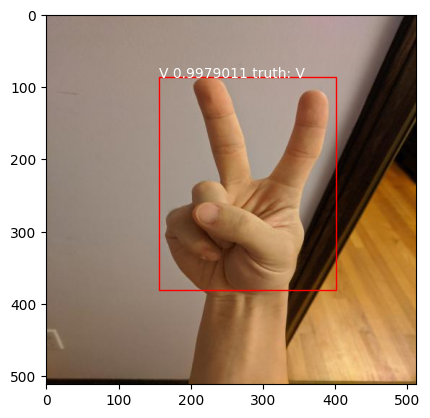

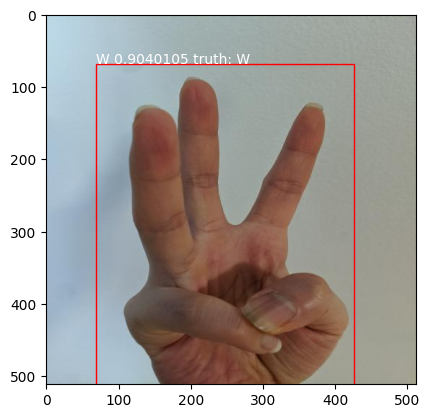

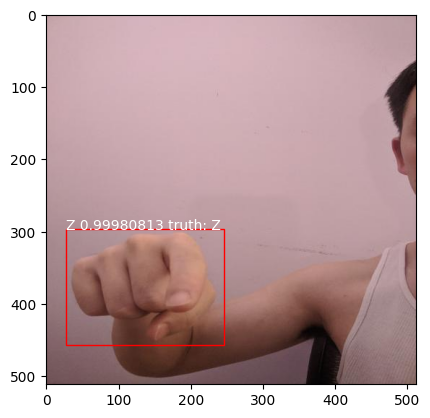

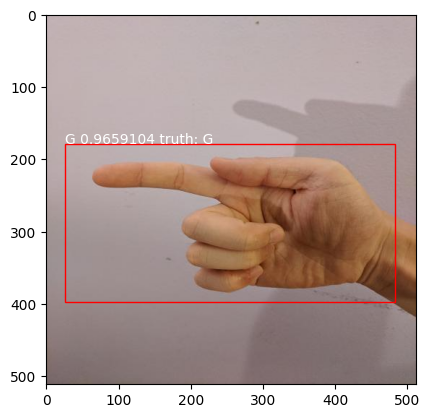

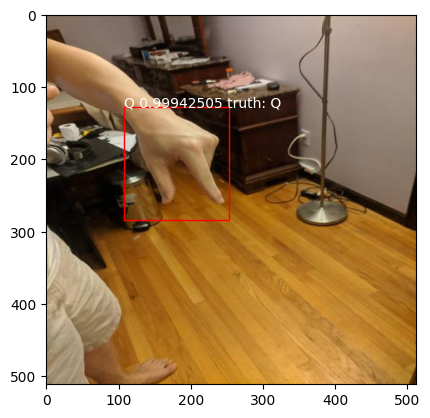

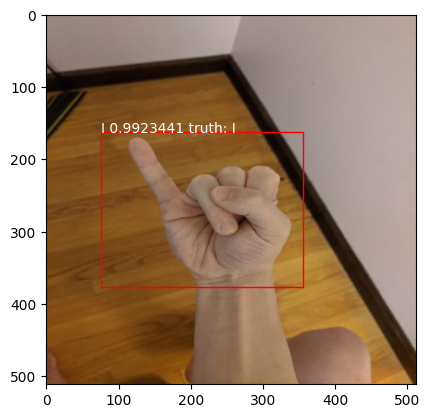

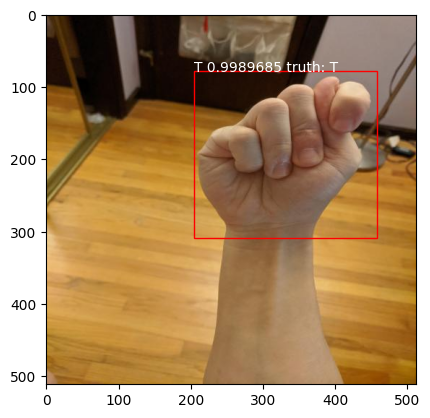

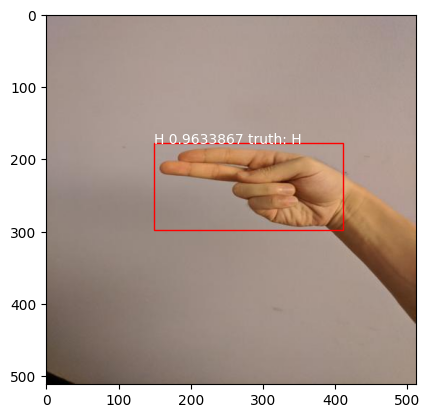

In [15]:
# visualize
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
imgs = []

for i in range(8):
    if i % 4 == 0:
        sample_img, sample_target = next(iter(test_dataloader))
    with torch.no_grad():
        output = model([sample_img[i%4].to(device)])
    fig, ax = plt.subplots(1)
    ax.imshow(sample_img[i%4].permute(1, 2, 0).cpu().numpy())

    # get bounding box
    box = output[0]['boxes'][0].cpu().numpy()

    # get class
    cls = output[0]['labels'][0].cpu().numpy()

    # get score
    score = output[0]['scores'][0].cpu().numpy()

    # draw bounding box
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    # add class name and score
    ax.text(box[0], box[1],  valToChar(cls)+ ' ' + str(score) + ' truth: ' + valToChar(sample_target[i%4]['labels'][0].cpu().numpy()), color='w')

plt.show()